In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Requirements

- DIY clustering algorithm (i.e. K-means)
- Compare results with scikit-learn implementation
- Validate and compare different models and/or parameter sets
- Feature engineering (various feature combinations, etc)
- Interpret results

# Preparation

Data source: https://www.kaggle.com/ueslei/ucs-satellite-database

In [2]:
df = pd.read_csv('../2_EDA/ucs-satellite-database/UCS_Satellite_Database_12-1-2018-1.csv',
    engine='python', decimal=',', thousands='.', parse_dates=['Date of Launch'], dayfirst=True)

# Remove some columns
df.drop(df.columns[df.columns.tolist().index('Comments')+1:], axis=1, inplace=True)

# Type conversions
df['Eccentricity'] = df['Eccentricity'].replace(',', '.', regex=True).astype(float)
df['Inclination (degrees)'] = df['Inclination (degrees)'].replace(',', '.', regex=True).astype(float)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 27 columns):
Name of Satellite, Alternate Names    1957 non-null object
Country/Org of UN Registry            1957 non-null object
Country of Operator/Owner             1957 non-null object
Operator/Owner                        1957 non-null object
Users                                 1957 non-null object
Purpose                               1957 non-null object
Detailed Purpose                      720 non-null object
Class of Orbit                        1955 non-null object
Type of Orbit                         1348 non-null object
Longitude of GEO (degrees)            1956 non-null object
Perigee (km)                          1957 non-null float64
Apogee (km)                           1957 non-null int64
Eccentricity                          1957 non-null float64
Inclination (degrees)                 1957 non-null float64
Period (minutes)                      1957 non-null float64
Launch

## Features

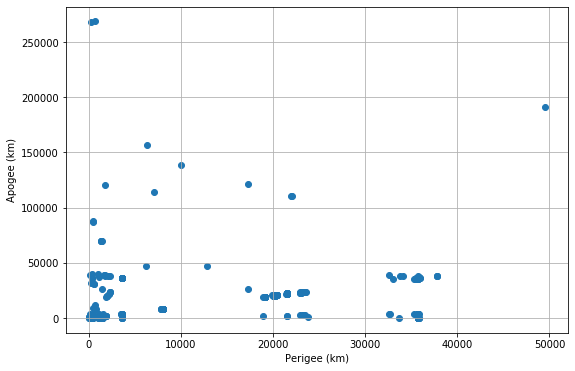

In [4]:
# Two features: lowest and highest point in orbit (perigee/apogee)
plt.figure(figsize=(9, 6))
plt.scatter(df['Perigee (km)'], df['Apogee (km)'])
plt.xlabel('Perigee (km)')
plt.ylabel('Apogee (km)')
plt.grid()

In [5]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df[['Perigee (km)', 'Apogee (km)']].values
X = scaler.fit_transform(X)

# K-means clustering

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

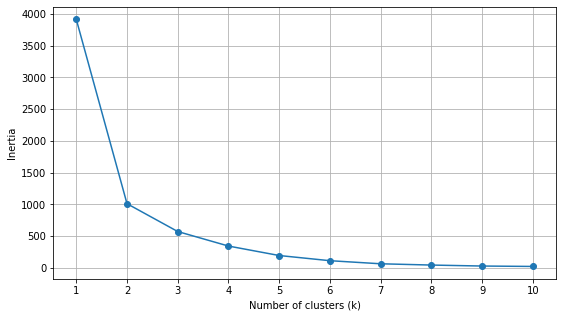

In [7]:
# Inertia scores
inertia_scores = []
k_values = list(range(1, 10 + 1))
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(X)
    inertia_scores.append(kmeans.inertia_)
    
plt.figure(figsize=(9, 5))
plt.plot(k_values, inertia_scores, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid()

/home/tomas/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


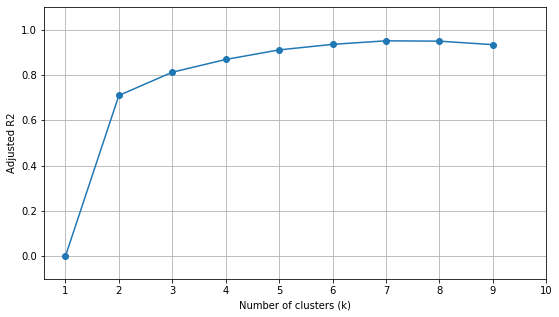

In [8]:
# Adjusted R2
n = max(k_values)
adjusted_r2_scores = [
    1 - ((inertia * (n - 1)) / (inertia_scores[0] * (n - k)))
    for inertia, k in zip(inertia_scores, k_values)
]

plt.figure(figsize=(9, 5))
plt.plot(k_values, adjusted_r2_scores, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Adjusted R2')
plt.ylim([-0.1, 1.1])
plt.grid()

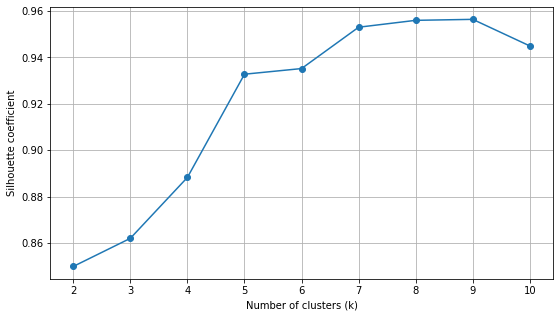

In [9]:
# Silhouette coefficient
silhouette_scores = []
k_values = list(range(2, 10 + 1))
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(X)
    score = silhouette_score(X, y_pred)
    silhouette_scores.append(score)

    
plt.figure(figsize=(9, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette coefficient')
plt.grid()

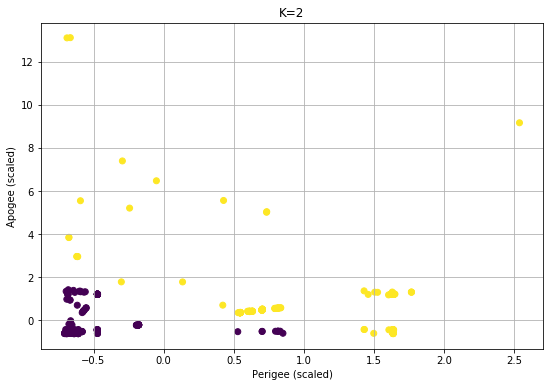

In [10]:
kmeans_2 = KMeans(n_clusters=2)
kmeans_2_pred = kmeans_2.fit_predict(X)

plt.figure(figsize=(9, 6))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_2_pred)
plt.xlabel('Perigee (scaled)')
plt.ylabel('Apogee (scaled)')
plt.title('K=2')
plt.grid()

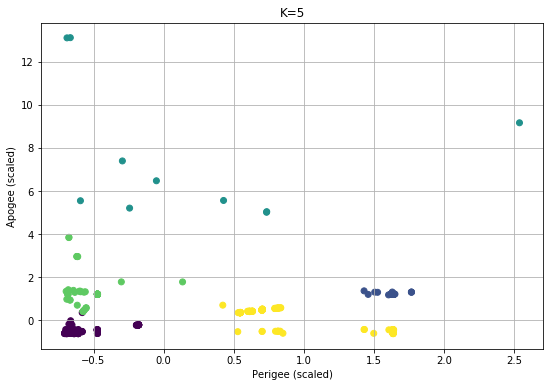

In [11]:
kmeans_5 = KMeans(n_clusters=5, random_state=12)
kmeans_5_pred = kmeans_5.fit_predict(X)

plt.figure(figsize=(9, 6))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_5_pred)
plt.xlabel('Perigee (scaled)')
plt.ylabel('Apogee (scaled)')
plt.title('K=5')
plt.grid()

### Interpretation

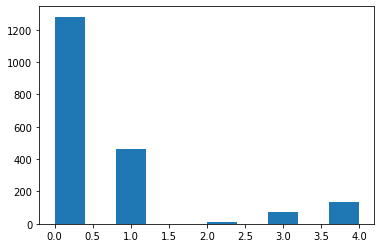

In [12]:
# Cluster sizes
plt.figure()
plt.hist(kmeans_5_pred)
plt.show()

In [13]:
# Cluster centers
# Note the reverse of scaling operation!
scaler.inverse_transform(
    kmeans_5.cluster_centers_)

array([[   749.94379391,    825.88992974],
       [ 35757.76572668,  35837.98047722],
       [ 13685.3       , 160102.6       ],
       [  2746.16901408,  37930.64788732],
       [ 24923.09701493,  14596.58208955]])

In [ ]:
# Cluster 1 - satellites with circular low earth orbit (LEO)
# Cluster 2 - satellites with circular geostationary orbit (GEO)
# Cluster 3 - satellites with very elliptical orbit and high apogee
# Cluster 4 - satellites with very elliptical orbit and medium apogee
# Cluster 5 - satellites with less elliptical orbit and medium perigee/apogee

# Hierarchical clustering

In [14]:
# From scikit-learn examples:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

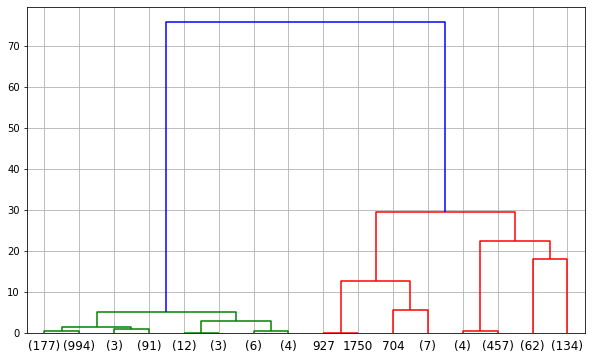

In [15]:
from sklearn.cluster import AgglomerativeClustering

# Default linkage method is Ward
hc0 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hc0.fit(X)

plt.figure(figsize=(10, 6))
plot_dendrogram(hc0, truncate_mode='level', p=3)
plt.grid()

In [16]:
# Specifying distance threshold instead of number of clusters:
hc = AgglomerativeClustering(distance_threshold=25, n_clusters=None)
hc_pred = hc.fit_predict(X)

# Optimal number of clusters could also be determined by 
# largest vertical distance which does not intersect any other clusters.

## Interpretation

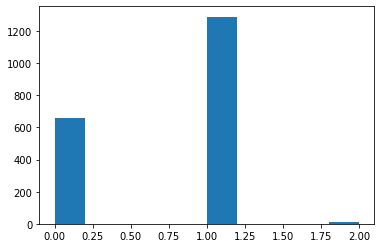

In [17]:
# Cluster sizes
plt.figure()
plt.hist(hc_pred)
plt.show()

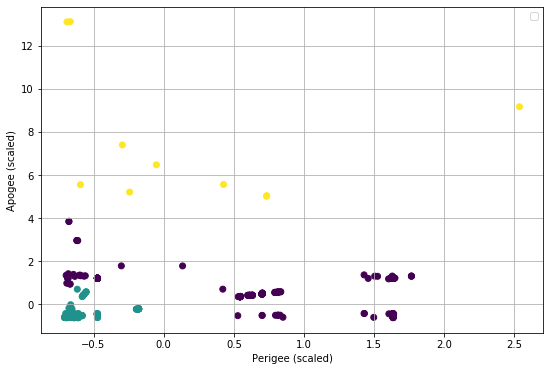

In [18]:
plt.figure(figsize=(9, 6))
plt.scatter(X[:, 0], X[:, 1], c=hc_pred)
plt.xlabel('Perigee (scaled)')
plt.ylabel('Apogee (scaled)')
plt.legend()
plt.grid()

# More ideas
- Different models (https://scikit-learn.org/stable/modules/clustering.html)
- Different feature sets (more than 2 features, PCA transform for visualization, etc)
- Different evaluation metrics, cluster counts, etc
- Different ways of interpreting the clusters